In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
item=pd.read_csv("olist_order_items_dataset.csv")
order=pd.read_csv("olist_orders_dataset.csv")
product=pd.read_csv("olist_products_dataset.csv")
customer=pd.read_csv("olist_customers_dataset.csv")
review=pd.read_csv("olist_order_reviews_dataset.csv") 
payment=pd.read_csv("olist_order_payments_dataset.csv")

In [47]:
df1=pd.merge(customer.drop(columns=['customer_zip_code_prefix']),order[['customer_id','order_id','order_purchase_timestamp']],on='customer_id')

In [48]:
df2 = pd.merge(df1,review[['order_id','review_score']],on='order_id')

In [49]:
paid = payment[['order_id','payment_value']].groupby('order_id').sum().reset_index()

In [50]:
df3 = pd.merge(df2,paid,on='order_id')

In [51]:
df3['order_purchase_timestamp']=pd.to_datetime(df3['order_purchase_timestamp']).dt.date

In [52]:
df3['order_purchase_timestamp']

0        2017-05-16
1        2018-01-12
2        2018-05-19
3        2018-03-13
4        2018-07-29
            ...    
99218    2018-04-07
99219    2018-04-04
99220    2018-04-08
99221    2017-11-03
99222    2017-12-19
Name: order_purchase_timestamp, Length: 99223, dtype: object

In [53]:
number_of_days_for_purchase=180
max_date_in_data= df3['order_purchase_timestamp'].max()

In [54]:
min_date_in_data= df3['order_purchase_timestamp'].min()

In [55]:
min_date_in_data

datetime.date(2016, 9, 4)

In [56]:
from datetime import datetime, timedelta 

In [57]:
max_date_in_data

datetime.date(2018, 10, 17)

In [58]:
data_split_date=max_date_in_data -timedelta(days=number_of_days_for_purchase)

In [59]:
data_split_date

datetime.date(2018, 4, 20)

In [60]:
df_full=df3[df3['order_purchase_timestamp']<=data_split_date]
df_last=df3[df3['order_purchase_timestamp']>data_split_date]

In [61]:
df_last_180 =pd.DataFrame({'customer_unique_id':df3['customer_unique_id'].values.tolist()})

In [62]:
df_last_180=df_last_180.merge(df_last.groupby(['customer_unique_id'])['payment_value'].sum().reset_index(),how='outer',on='customer_unique_id')

In [63]:
df_last_180.fillna(0,inplace=True)

In [64]:
df_last_180['purchased']=np.where(df_last_180['payment_value']>0, 1,0)

In [65]:
df_last_180.head()

,customer_unique_id,payment_value,purchased
0,861eff4711a542e4b93843c6dd7febb0,0.00,0
1,290c77bc529b7ac935b93aa66c333dc3,0.00,0
2,060e732b5b29e8181a18229c7b0b2b5e,157.73,1
3,259dac757896d24d7702b9acbbff3f3c,0.00,0
4,345ecd01c38d18a9036ed96c73b8d066,252.25,1


In [66]:
## total amount per customer
tot_Amount=df_full.groupby('customer_unique_id')['payment_value'].sum().reset_index().rename(columns={'payment_value':'total_amount'})

In [67]:
## average review given
avg_review=df_full.groupby('customer_unique_id')['review_score'].mean().reset_index().rename(columns={'review_score':'avg_review'})

In [68]:
## months between first purchase and today
min_max_date=df_full.groupby('customer_unique_id')['order_purchase_timestamp'].agg([min,max])
min_max_date['diff_first_today']=(datetime.today().date()-min_max_date['min']).dt.days

In [69]:
## months from first to last purchase
min_max_date['max']=pd.to_datetime(min_max_date['max'])
min_max_date['min']=pd.to_datetime(min_max_date['min'])
min_max_date['diff_first_last']=(min_max_date['max']-min_max_date['min']).dt.days

In [70]:
## recency of Sales 
max_date=df_full['order_purchase_timestamp'].max()

min_max_date['recency']=(np.datetime64(max_date)-min_max_date['max'])/np.timedelta64(1, 'M')

In [71]:
## Frequency of Sales
frequency=df_full.groupby('customer_unique_id')['order_id'].count().reset_index().rename(columns={'order_id':'frequency'})

In [72]:
## joining all the engineered features
dataset=pd.merge(tot_Amount,avg_review,on='customer_unique_id')
dataset=pd.merge(dataset,min_max_date,on='customer_unique_id')
dataset=pd.merge(dataset,frequency,on='customer_unique_id')
dataset=pd.merge(dataset,df_full[['customer_unique_id','customer_city','customer_state']],on='customer_unique_id')
dataset.drop(['min','max'],axis=1,inplace=True)

In [73]:
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler

In [74]:
### label encoding city and state names
encoder=LabelEncoder()
dataset['customer_city']=encoder.fit_transform(dataset['customer_city'])
dataset['customer_state']=encoder.fit_transform(dataset['customer_state'])

In [75]:
##merging with the label dataset we have created 
dataset_full=dataset.merge(df_last_180[['customer_unique_id','purchased']],on='customer_unique_id')
dataset_full.drop(columns='customer_unique_id',inplace=True)

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import r2_score,accuracy_score,classification_report
# Splitting data into training/testing
from sklearn.model_selection import train_test_split,GridSearchCV

In [77]:
#splitting to train and test dataset
X_train,X_test,y_train,y_test=train_test_split(dataset_full.iloc[:,:-1],dataset_full.iloc[:,-1], test_size=0.2, random_state=31)

In [78]:
#calculating gini scores for the models
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

In [79]:
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression',
                      'Random Forest', 'Extra Trees',
                       'Gradient Boosted','KNeighbors']

    
    # Instantiate the models
    model1 = LinearRegression()
    model3 = RandomForestClassifier(n_estimators=50)
    model4 = ExtraTreesClassifier(n_estimators=50)
    model6 = GradientBoostingClassifier(n_estimators=20)
    model7= KNeighborsClassifier(n_neighbors = 5)
    results = pd.DataFrame(columns=['r2', 'accuracy','gini'], index = model_name_list)
    for i, model in enumerate([model1, model3, model4, model6,model7]):
   
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
               
        # Metrics
        r2 = r2_score(y_test,predictions)
        preds=np.where(predictions>0.5,1,0)
        accuracy = accuracy_score(y_test,preds)
        gini=Gini(y_test,preds)
        # Insertion of  results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [r2, accuracy,gini]
    
    return results

In [80]:
results=evaluate(X_train, X_test, y_train, y_test)

In [81]:
results

,r2,accuracy,gini
Linear Regression,0.047211,0.97692,0.00262
Random Forest,0.829861,0.996164,0.880302
Extra Trees,0.796391,0.995409,0.88804
Gradient Boosted,0.09352,0.979561,0.118698
KNeighbors,0.283183,0.983837,0.406596


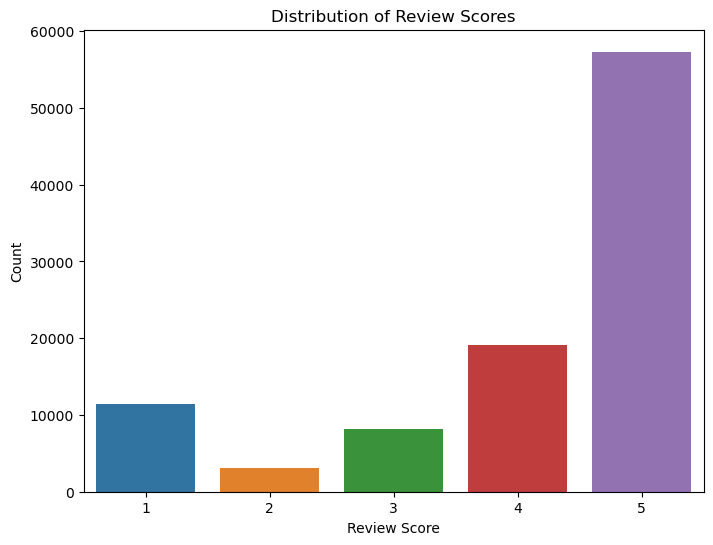

In [82]:
#barlplot
plt.figure(figsize=(8, 6))
sns.countplot(x='review_score', data=df3)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

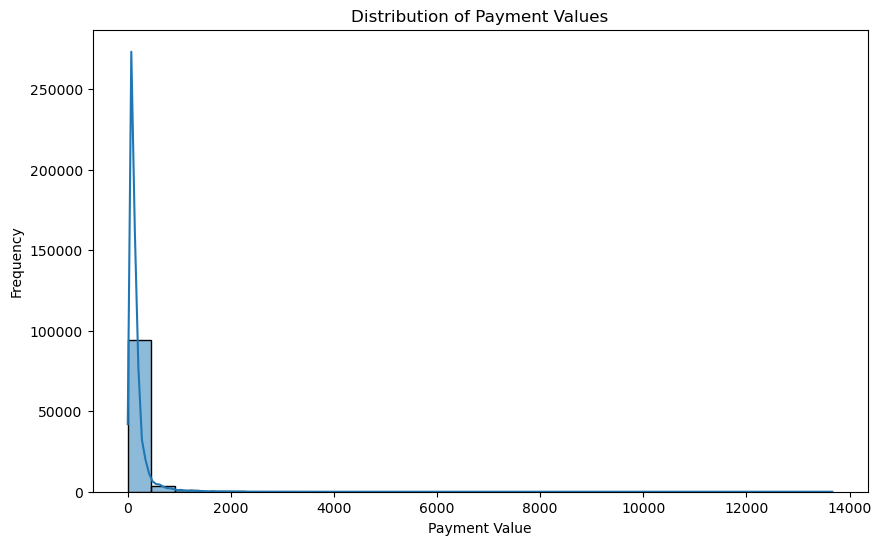

In [83]:
#histogram
plt.figure(figsize=(10, 6))
sns.histplot(df3['payment_value'], bins=30, kde=True)
plt.title('Distribution of Payment Values')
plt.xlabel('Payment Value')
plt.ylabel('Frequency')
plt.show()


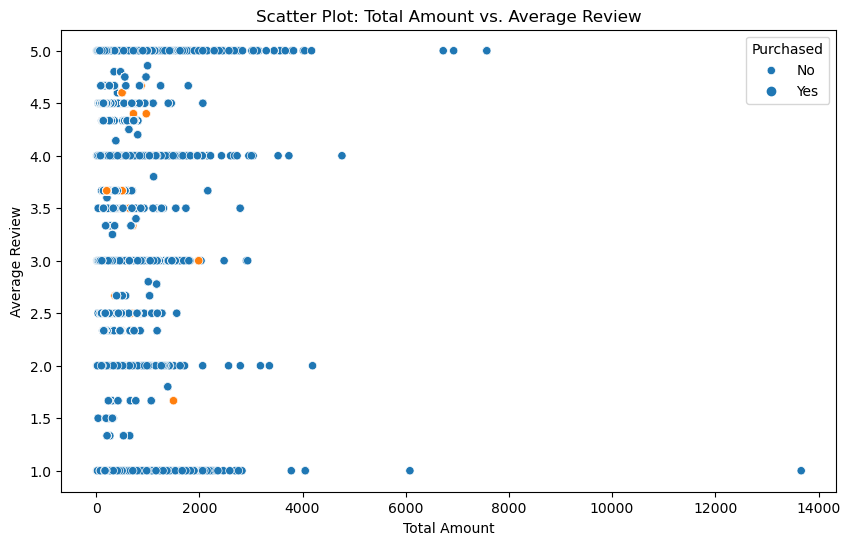

In [84]:
#Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_amount', y='avg_review', data=dataset_full, hue='purchased')
plt.title('Scatter Plot: Total Amount vs. Average Review')
plt.xlabel('Total Amount')
plt.ylabel('Average Review')
plt.legend(title='Purchased', loc='upper right', labels=['No', 'Yes'])
plt.show()

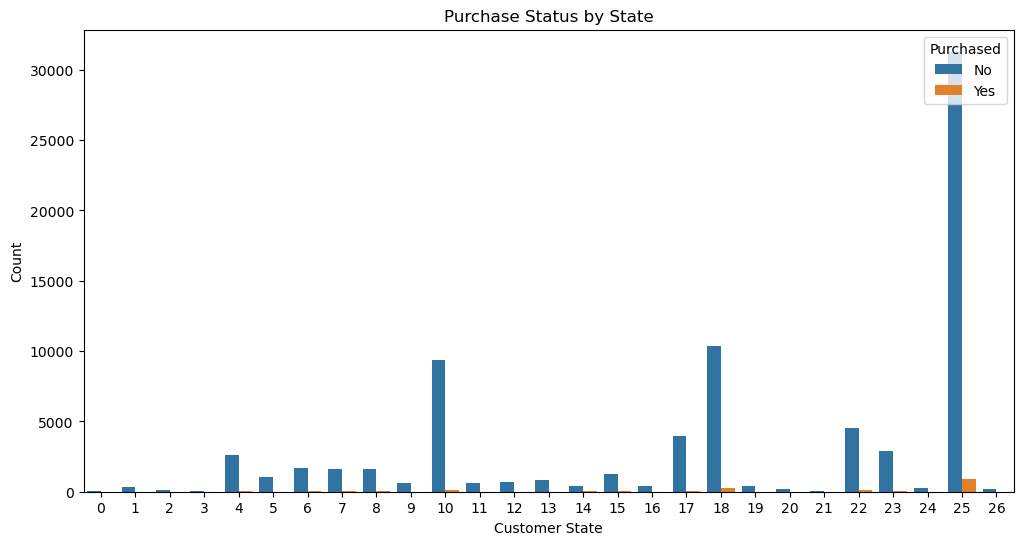

In [85]:
#Bar Plot 
plt.figure(figsize=(12, 6))
sns.countplot(x='customer_state', data=dataset_full, hue='purchased')
plt.title('Purchase Status by State')
plt.xlabel('Customer State')
plt.ylabel('Count')
plt.legend(title='Purchased', loc='upper right', labels=['No', 'Yes'])
plt.show()